# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [3]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import re
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

# Function for feature building and extraction on natural language data

In [27]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
#     toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
#     toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['ep_count'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['hell_count'] = toxic_data['comment_text'].str.count("hell") + toxic_data['comment_text'].str.count("HELL") #str.lower() threw an error
    toxic_data['upper_ratio'] = toxic_data['comment_text'].str.count(r'(?<!\s)[A-Z]')#/toxic_data['comment_text'].str.count("\.") #other ways re.findall and looping with isupper returned the same value for each row

#     X_quant_features = toxic_data[["word_count", "punc_count"]]
    X_quant_features = toxic_data[["ep_count", "hell_count", "upper_ratio"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [28]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/agbro/Documents/machine-learning/toxic-comments/toxiccomments_train.csv', my_random_seed=22)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [29]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

C:\Users\agbro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 12916, 'Neg': 114740, 'TP': 6320, 'TN': 57229, 'FP': 57511, 'FN': 6596, 'Accuracy': 0.4978144388042865, 'Precision': 0.09901145211574314, 'Recall': 0.4893155775781976, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [30]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 12401, 'TN': 114158, 'FP': 582, 'FN': 515, 'Accuracy': 0.9914065927179294, 'Precision': 0.9551721481937919, 'Recall': 0.9601269742954475, 'desc': 'svm_train'}


### MODEL: logistic regression

In [31]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 12411, 'TN': 114152, 'FP': 588, 'FN': 505, 'Accuracy': 0.9914379269286206, 'Precision': 0.9547657512116317, 'Recall': 0.9609012078042738, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [32]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 12673, 'TN': 105921, 'FP': 8819, 'FN': 243, 'Accuracy': 0.9290123456790124, 'Precision': 0.5896612693095105, 'Recall': 0.9811861257355219, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [33]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

C:\Users\agbro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 12916, 'Neg': 114740, 'TP': 12429, 'TN': 114101, 'FP': 639, 'FN': 487, 'Accuracy': 0.991179419690418, 'Precision': 0.9511019283746557, 'Recall': 0.9622948281201611, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [47]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 10794, 'TN': 114622, 'FP': 118, 'FN': 2122, 'Accuracy': 0.9824528420129097, 'Precision': 0.9891862170087976, 'Recall': 0.8357076494270672, 'desc': 'rdg_train'}


In [49]:
# from sklearn import linear_model
rdg_pt5 = linear_model.RidgeClassifier(alpha = .5)
rdg_pt5.fit(X_train, y_train)

rdg_pt5_performance_train = BinaryClassificationPerformance(rdg_pt5.predict(X_train), y_train, 'rdg_pt5_train')
rdg_pt5_performance_train.compute_measures()
print(rdg_pt5_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 10794, 'TN': 114625, 'FP': 115, 'FN': 2122, 'Accuracy': 0.9824763426709281, 'Precision': 0.9894582454853791, 'Recall': 0.8357076494270672, 'desc': 'rdg_pt5_train'}


In [50]:
# from sklearn import linear_model
rdg_1pt5 = linear_model.RidgeClassifier(alpha = 1.5)
rdg_1pt5.fit(X_train, y_train)

rdg_1pt5_performance_train = BinaryClassificationPerformance(rdg_1pt5.predict(X_train), y_train, 'rdg_1pt5_train')
rdg_1pt5_performance_train.compute_measures()
print(rdg_1pt5_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 10799, 'TN': 114625, 'FP': 115, 'FN': 2117, 'Accuracy': 0.9825155104342922, 'Precision': 0.9894630749496061, 'Recall': 0.8360947661814804, 'desc': 'rdg_1pt5_train'}


In [51]:
# from sklearn import linear_model
rdg_5 = linear_model.RidgeClassifier(alpha = 5)
rdg_5.fit(X_train, y_train)

rdg_5_performance_train = BinaryClassificationPerformance(rdg_5.predict(X_train), y_train, 'rdg_5_train')
rdg_5_performance_train.compute_measures()
print(rdg_5_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 10797, 'TN': 114624, 'FP': 116, 'FN': 2119, 'Accuracy': 0.9824920097762737, 'Precision': 0.989370475579584, 'Recall': 0.8359399194797151, 'desc': 'rdg_5_train'}


In [52]:
# from sklearn import linear_model
rdg_10 = linear_model.RidgeClassifier(alpha = 10)
rdg_10.fit(X_train, y_train)

rdg_10_performance_train = BinaryClassificationPerformance(rdg_10.predict(X_train), y_train, 'rdg_10_train')
rdg_10_performance_train.compute_measures()
print(rdg_10_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 10797, 'TN': 114624, 'FP': 116, 'FN': 2119, 'Accuracy': 0.9824920097762737, 'Precision': 0.989370475579584, 'Recall': 0.8359399194797151, 'desc': 'rdg_10_train'}


### MODEL: Random Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

C:\Users\agbro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12916, 'Neg': 114740, 'TP': 0, 'TN': 114740, 'FP': 0, 'FN': 12916, 'Accuracy': 0.8988218336780096, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\agbro\Documents\machine-learning\toxic-comments\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

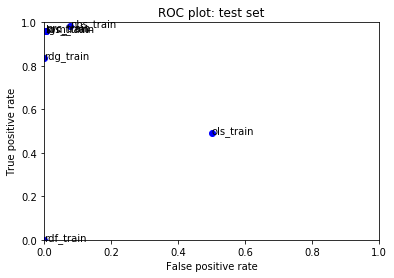

In [48]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

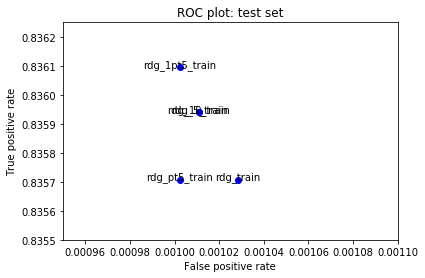

In [70]:
fits = [rdg_performance_train, rdg_pt5_performance_train, rdg_1pt5_performance_train, rdg_5_performance_train, rdg_10_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc, ha='center')
plt.axis([.00095, .0011, 0.8355, .83625])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [37]:
ols_predictions = ols.predict(X_train)

In [38]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
26
Ulster
I would like your opinion on the edits I made to the Plantation of Ulster section within the Ulster page.
* * * * * * * * * 
65
4.25 

I don't know if I missed something here, but I would like to know what these numbers relate to? 119.161.71.12  INFX.com.au
* * * * * * * * * 
108
I don't see how I am being disruptive either. I am simply following the dispute resolution procedure and participating in a discussion involving a large number of people about Wikifan12345's conduct.
* * * * * * * * * 
117
Thanks for the encouragement

But can't work out how to remove the cleanup notice from the henchman article...  23:10, 1 Oct 2004 (UTC)
* * * * * * * * * 
127
henry lee lucas was my dad im pretty sure i know the information better than you do.
* * * * * * * * * 
151
"

""Leaders of the Christian Reconstruction movement expect a large majority of citizens worldwide eventually to accept Christ as savior. We believe in postmillennialism. Those who do not s

1665
"

 Photo 

We need a photo for the article.  I could not find any decent ones on Flickr.  I am very much hoping to get permission for .  It appeared on this website suite101 (I couldn't provide a link because it was blocked by the spam filter, but you can find it by google image search) where it says ""credit: fan website"", and I would love to find the original source so we can ask for permission.  I believe the image's first appearance may have been [home.planet.nl/~brouw724/ images/tolle3.jpg here] but the page is now down.   "
* * * * * * * * * 
1750
"
Thanks, and it is great to hear from you, .  Let's discuss it "
* * * * * * * * * 
1757
Nor is the Falklands war, which demonstrated the continuing importance of manouverability in a close-quarters fight, in the early 1980's. I thought about correcting the article, but it requires such a fundamental re-write that this would be pointless.
* * * * * * * * * 
1786
"

Change my ways? I have been suspended 3 times and I have the sam

3375
Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
Tutorial
How to edit a page
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your messages on discussion pages using four tildes (~~~~); this will automatically insert your username and the date. If you need help, check out Wikipedia:Questions, ask me on , or ask your question on this page and then place {{helpme}} before the question. Again, welcome!  —' (talk) 

The article Sarah Ford has been speedily deleted from Wikipedia. This has been done under the criteria for speedy deletion, because it is a very short article providing little or no context to the reader. Please see Wikipedia:Stub for our minimum information standards for short articles. Please also note that articles must be on notable subjects and should cit

4827
"

Oh, that says ""Kim Il-sung City""! ""Si"" means a lot of things, but ""City"" in this context. Trolling is when an Internet user tries to hurt another's feelings (isn't it?) How would that Ref Desk entry hurt anyone and why?  "
* * * * * * * * * 
4855
"

, I'm now starting to get solid support at the AN/I.  I thank all the editors doing so (including yourself), but I won't mention names so that my doing so does not get them in trouble.   "
* * * * * * * * * 
4860
Slavery 

Karen seems to be on good terms with denominations that allow slavery. This contradicts her talk of the Golden Rule.
* * * * * * * * * 
4867
Right, basically, if something is confusing or poorly defined, feel free to clarify; saying what devil fruits are is something that should be in the article, but a list of all devil fruits should not be.
* * * * * * * * * 
4869
I'll look around this week, I'm sure I can find something.
* * * * * * * * * 
4907
Still, I regard this is another instance where I must ask som

6206
"

I would also point out that it seems strange for an admin to ""side"" with an anonymous editor whose only edits are to remove content from this article. The text isn't controversial, is referenced and it's removal is only on the basis of it suiting the other user who could actually be just about anyone.

92.8.29.174  "
* * * * * * * * * 
6213
"

Maybe you can also ""mediate"" T-Man's insane edit on Legends of the Dark Knight...  "
* * * * * * * * * 
6238
"

 Talkheader not necessary 

Just wanted to leave a quick note that the  banner should really only be used on pages where it's needed - where there is a lot of discussion and/or a heated debate.  Articles like Talk:The Dicks probably don't need it.  Thanks!   (talk / contribs) "
* * * * * * * * * 
6303
"
In good faith, where is the POV? I made several changes, including deleting ""penny bomb"" as you wished and correcting two sentences as you guided; so I don't know what you refer to, and wish to reach consensus with you.   "

7732
"

 Movie plots 

Hello... sorry to have to say this, but please refrain from deleting ""Plot"" sections, as you did at The Day After and The Descent. While The Day After could in fact use a trim, the proper approach is to tag it or rewrite it - not to delete the entire section. As for The Descent, the plot section was not overly long, and we don't remove material because of ""spoiler"" concerns. (Readers are expected to understand that an encyclopedic article will probably contain this sort of material.) Please feel free to ask if you have any questions about this. Thanks. ''''''chatspy "
* * * * * * * * * 
7773
"

Page overrun by Muslim POV pushers

I note that a number of Muslim Guild members are here and POV pushing heavily, screaming about ""talk page"" while never posting there and serially reverting proper material.  "
* * * * * * * * * 
7886
If you do not know which players were famous or noteable, leave it up to someone who does know. Don't undermine an article and make i

* * * * * * * * * 
9135
"

 Notability 

If you used a different word, maybe you would make yourself more clear. Notability, as per the wikipedia policy, is completely and utterly about articles, and in no way applies once an article is deemed notable. It has nothing to do with the contents of an article, or whether this or that should be added or removed. It says so right on the page. ""These notability guidelines only outline how suitable a topic is for its own article. They do not directly limit the content of articles""  "
* * * * * * * * * 
9197
This article is highly disorganized 

There is a lot of good material in here, but it seems to be arranged in no particular order. The level of exposition oscillates at high speed between what is appropriate for grade school and what is appropriate for graduate school. I am going to try to straighten things out a bit. Please help!
* * * * * * * * * 
9254
Blocked==
Wikipedia Administrators are cureently deciding whether you should be blocke

10475
That's Wehwalt.  It's been 20 years since I read the thing, but in the book there were those who felt that they could solve the country's severe economic problems by pressuring the intelligent to solve the problems.  They were not successful.  I do not think that if you put this into force, that admins facing reconfirmation would solve the problems of RfA.

I should add that I do support community desysoping.  I would favor that the RfDS would have to get a consensus to desysop, and possibly some minor restrictions, let's say seven days notice to the admin before you can start one, and perhaps each editor is limited to one attempt at a desysop per month.  And if the desysop fails, the admin cannot be taken down that road for six months.  That kinda thing.
* * * * * * * * * 
10533
Harassment 
OK, I will let harass this guy if he don't harass me with my editing that isn't vandalic. 190.158.7.14
* * * * * * * * * 
10591
"
The original argument between us began when you accused me of

12009
August 2006 (UTC)

Endorse Dmcdevits request. And I think you shouldn't go for another RfA. This is not because of the self-unblocking. It's because you block far too much and for things that aren't in accordance with WP policies, you made more than one mistake already. I also find your over-commitment to the project worrying. RfA shouldn't bring you so much stress, it's a virtual community thing, not something your or other's life would depend on and your real life isn't on display actually. It is not true that over-commited people work the best. Realistic and cool people do. Ackoz 21:20, 8
* * * * * * * * * 
12012
HighBeam 

Hi, I want to email you your activation code, but your email is not set up.  Please provide one at Special:Preferences.  Or, email me with your username at wikiocaasi@yahoo.com.  Cheers,  t | c
* * * * * * * * * 
12027
"== EF ==

Were the major content-kill edits reversed?  
See your talk comments on the page linked in this section header.   
OK, I was wait

13798
I added her right. mango
* * * * * * * * * 
13824
Bristol-Plymouth Regional Technical School 

Hi, Artsyfrenchie and welcome to Wikipedia.  The school article you chose to edit for your first edit is a really bad article.  It would be wonderful if you would try to improve it.  Please look at some other school articles and see what they look like and take a look at the guidelines for school articles (WP:WPSCHOOLS/AG) before you do.  You can always contact me on my talk page if you need any help and I will leave you an invitation to a Q&A; forum for newer users where they specialize in giving simple answers for complicated questions.  Thanks for joining the team of Wikipedia editors.  We hope you stick around!
* * * * * * * * * 
14042
"

 Barnstar 

Hey Dan9186, allow me to give you this award for your great work on merging the TN county related lists into a single list that contains all the relevant information about TN counties. 

  The Working Man's Barnstar For great work on th

15804
Your edit to the article World population has been reverted. If you would like to test edits, please use the Sandbox. Thank you.
* * * * * * * * * 
15971
, 13 April 2006 (UTC)

Well-where is the answer to this ? What about Starčević's admirers, from Matoš to Krleža ? 19:48
* * * * * * * * * 
15980
Arbitration enforcement warning: Armenia Azerbaijan 2
Please see this .
* * * * * * * * * 
16005
"

Talkback

Questions by  Kangaroo "
* * * * * * * * * 
16006
"

 What does Pretty Lou do? 

Mr. Cheeks is the main MC, Freaky Ty is the Hypeman, Spigg Nice is the ""DJ"", What the hell does Pretty Lou do? His only contribution to any album is on the Legal Drug Money where he say's ""Talik What's up my man"", and he's not even rapping it he just says it on a song, seems like he was really there to just be pretty lol."
* * * * * * * * * 
16034
"
Editors are responsible for information they add to an article. I do not have any information as to where she is buried other than the reliable sour

17194
"

 ISBN of Portrait of the Cheshire Lines Committee 

Hi, following up on your revert of my (and 's) changes to Ainsdale Beach railway station. According to WorldCat, the ISBN of Portrait of the Cheshire Lines Committee is in fact 0-7110-2521-5 (or 978-0-7110-2521-9; they're equivalent). The ISBN ""0 7110 2512 5"" is invalid; the check digit ""5"" at the end doesn't match up with the rest of the number. I built a tool for working with ISBNs, and it also shows that this one is incorrect. Even if the incorrect version appears in the book, libraries are likely to be listing it under the corrected version—Wikipedia should too. {{ |talk |edits}} "
* * * * * * * * * 
17263
"
Well, I think you have the right of giving him a Barnstar yourself. I think anyone can.  "
* * * * * * * * * 
17360
Please don't vandalize Wikipedia!
* * * * * * * * * 
17407
"
While in August 19, jimbo did change it to guideline, it was disputed for some time afterwards. SWATJester Denny Crane. "
* * * * * * * * 

19199
This talk page is dead, so I'm going to do the edit now and if anyone wants to dispute comment here.
* * * * * * * * * 
19433
It doesn't mean `legal', though. ... al  bin Baloney (Hows my driving?)
* * * * * * * * * 
19504
I wonder why you think it's absurd to a) try and raise funds for those harmed by a natural disaster and b) to prove once and for all that these repetitive - almost chanting - claims I am Ennis are false. If the 'Number is Ennis' dichotomy was removed the Talk Pages would be near empty! I wonder why you condemn my attempts to bring honesty to these pages.

But, that's rhetorical - as I said, there must be certain camaraderie among Wiki people and I doubt if you’d want to jeopardise that even if your quest was integrity.

Now you have asked me a sensible question, so I'll answer.

For some time I watched these pages and saw that posts from people in the UK/claiming they were in the UK were summarily dismissed. Worse, posters were automatically accused of being En

20854
Holy Isle 

I dont think the gaelic stuff is really nessicary Grinner. Do it again and I'll issue you with a ban.
* * * * * * * * * 
20920
I can't imagine how the following portion of the introduction can be modified to be relevant enough to the Big Bang theory to include so prominently.  This exterpt is strictly a (poorly written, in my opinion) cosmogony discussion which the current Big Bang  theory does not encompass.  Could someone make modifications to this portion of the article which would make it relevent?  Otherwise I'll delete it in a few days.  07:32, 2005 Jan 13 (UTC)

There are actually many theories about the Big Bang. Some theories purport to explain the cause of the Big Bang itself (First cause), and as such have been criticized as being modern creation myths. Some people believe that the Big Bang theory lends support to traditional views of creation, for example as given in Genesis, while others believe that all Big Bang theories are inconsistent with such views.

23302
"

Notability: 

""Published authors, editors and photographers who received multiple independent reviews of or awards for their work.""

David Roati has received awards for his work. It is stated in the biography.

 "
* * * * * * * * * 
23396
Hello Hold up first of all, you got it ALL mixed up. He's the one replacing sourced facts with his racist bias opinions and beliefs to this article. Im simply reverting it back to it's original content. You should block him for vandalism.
* * * * * * * * * 
23437
Commendation 

I don't believe it. A Wikipedia article written by a highly informed expert, with truly extensive and in-depth coverage.  Just commendable. Now delete the other 3,999,999 articles and start them over.

Jim Luedke
* * * * * * * * * 
23486
It appears that you are not helping me to post something that is informative and consistent with Wiki policies. Instead, you delete all my effort to put a factual statement and reference.  I am not a regular Wiki user and need help d

26100
Nicole Richie relation 

Is it true that Nicole Richie and Christy Hemme are related? I mean, they look so much alike.
* * * * * * * * * 
26130
What? There should be a single article titled List of tallest buildings in Manila. We don't need this level of specificity.
* * * * * * * * * 
26142
"
Of course! I've filed a TR. '''''''' '' "
* * * * * * * * * 
26224
Natasha/Aimee,is a fine specimen.
* * * * * * * * * 
26338
There we go guys, some GNU'd uniforms. FRACTIONS (t | c)
* * * * * * * * * 
26403
" YC did not released an independent album called ""Bands"""
* * * * * * * * * 
26413
Question 

Would you be tempted to list Template:Internet memes for deletion again? Your statement at Wikipedia:Deletion_review/Log/2008_November_30 still holds true. I think it was kept due to WP:INTERESTING/WP:LIKE/WP:USEFUL votes and the original problem wasn't solved.
* * * * * * * * * 
26479
"

My error, Bugs also mentioned this ""yet-to-be player"". Is this because he ""hasn't played an NFL down?

28395
"
You said that, not me ! ≈talk≈ "
* * * * * * * * * 
28398
Rockford First

Hey Jim, 
I am on the home stretch ( or so I hope) to getting the site up and running.  I was able to get a few pictures that I have from our church archives.  I am having a few issues with Wiki commmons. However, as soon as I get them licensed and such I will get it all figured out.  Could you do a thorough proofing of the article again to see what I could change to make it better.  I have tried to keep neutral and just informational.  Let me know!  Thank you so much!
* * * * * * * * * 
28423
{{Subst:Welcome}] Cheers,
* * * * * * * * * 
28465
"
 Right. So, my comments are first removed and then archived and deemed ""irrelevant"" without any logical explanation. I'm sorry but I couldn't have given a more polite response to that sort of behavior. I'm not a diplomat.   "
* * * * * * * * * 
28541
Isn't this against Wiki's policies? 

http://en.wikipedia.org/w/index.php?title=Talk%3AAl-Khwarizmi&diff;=4250205

30135
"
Hi, thank you for taking the matter seriously, your efforts are much appreciated. While the sources don't actually say they're the children of David Cross, I'm happy to assume good faith on the matter, though it'd be nice if there was a source somewhere that said he did have 3 children, I'll have a look see if I can dig anything up. Better not go into any more detail, though, or it'll read like one of those ""what my family did this year"" circulars that people send round at Christmas -) cheers,   "
* * * * * * * * * 
30251
don't need pimple faced kids editing my work
* * * * * * * * * 
30318
"

 You should wait for others to write an article about subjects in which you are personally involved. This applies to articles about you, your achievements, your band, your business, your publications, your website, your relatives, and any other possible conflict of interest. 

Creating an article about yourself is strongly discouraged. If you create such an article, it might be listed o

* * * * * * * * * 
32328
I know that you read it here!  

Luister Pejman. Learn better the Dutch language and integrate better in Holland instead vandalizing the wikipedia with your two usernames. You think you are an important person? What a joke. Soon your page will be deleted. Be modest and not such a high ego Mr. Pejman Akbarzadeh. We have tolerated you too long. You should be blocked and your article should be deleted per Wikipedia's rules! Wees dankbaar!
* * * * * * * * * 
32415
Oh no, no, no, no, I wasn't implying you were being uncivil; it was just a general comment about the nature of AfD.  When I was a newbie, I was often thinking, man, when are they going to close this?  It's a common complaint- note the AfD- or VfD, as it was then- on Autocunnilingus, where people were really getting annoyed.  Et tu, Brute?
* * * * * * * * * 
32533
Ballon d'Or

I listed two teams because Ronaldo spent half a season with one and the other half with the other, so yeah I am correct in listing 

34624
"

 pic for storm 

Hi Julian, which is the best map for display at F and A?  (talk) "
* * * * * * * * * 
34680
Kelly Rowland article 

Why do you keep undo ing my work?? i changed the image in the infobox to a more recent image as that is what you are meant to do! i am only trying to make the article look better but for you undo-ing my work is not making it any better. please, can you stop undo-ing it. thank you Ozurbanmusic
* * * * * * * * * 
34738
Request edits
http://www.businessinsider.com/cnbc-beat-cnn-in-primetime-monday-night-thats-really-bad-for-cnn-2010-8

CNBC beats CNN, therefore CNN now only on 4th place after Fox News, MSNBC and CNBC. This edit should be made to the article. 188.23.191.16
* * * * * * * * * 
34755
. All that effort was wasted. (People who ask a question and then come back to read the answer are also not going to be able to find it)
* * * * * * * * * 
34760
Terminological exactitude 

Thanks for taking the trouble to consider my views on the B talk pa

39885
"

 I'm not active nor interested in helping this site anymore, but as of the day of the posting, both publishers had lists of books on webscriptions. Further, I phoned Arnold and made some direct queries to make sure I had things straight. Some around here might consider that as OR, but the facts are right... or were. Haven't been there in what? something around or over a year, iirc. So from my point of view, consider it a  with that as the accessdate= field with backup. Arnold was also listing a couple of much smaller publishers as well. So... I may make a rare joke in content when the random circumstances align, but not at the expense of a point of fact. I'm well over 7,000 articles edited, so I'm hardly into making things up. Arnold Bailey (owner-operator)& webscriptions is an independent (Of Baen) businessman in the south somewhereone of the Carolina's. Baen is a NYC region publisher. Why would you assume a businessman isn't trying to improve his sales by increasing product 

44977
Former Porn Star turned P.I. PAUL BARRESI conduct investigations on behalf of dozens of Hollywood celebrities including:

TOM CRUISE
http://intouchweekly.hollywood.com/2007/11/hollywoods_biggest_rumor_answe.php

SYLVESTER STALLONE
http://abcnews.go.com/Primetime/LegalCenter/story?id=1625097&page;=1

ARNOLD SCHWARZENEGGER
http://www.laweekly.com/news/deadline-hollywood/arnold-pellicano-and-politics/9626/

EDDIE MURPHY
http://www.hollywoodinterrupted.com/archives/the_bagman.phtml

BARRY BONDS
http://thebiglead.com/?p=95

Since the dawning of the Internet, gossip can be disseminated around the world with the simple push of a button. 

Our First Amendment gives us the right to start a blog and publish whatever we wish to say about anybody.  It is much easier to be critical than correct. 
 
The freedoms we enjoy in the U.S are wonderful but they are also very dangerous. To create an unfavorable impression, it is not necessary that what is said be true.  The damage is done in the mere 

48613
CERTAIN SELF KINGS OF BS  LIKE biker SHOULD THINK BEFORE ANNOYING, OR THEY GET PAYBACK. IT'S LIKE YOU GET IN LIFE. HAD ENOUGH & MADE MY POINT
* * * * * * * * * 
48633
Minor Point of Style 
I recommend that the following two sentences be combined, to form the second paragraph. Apparently, User:Mel Etitis thinks otherwise.
     Numerous independent investigations have repeatedly proven it to be a plagiarism and a hoax.[1]
     Scholars generally agree that the Okhrana, the secret police of the Russian Empire,
     fabricated the text in the late 1890s or early 1900s.
Will Administrator Mel Etitis kindly explain himself - the reason for his effective reversion? -
* * * * * * * * * 
48684
"
At least it's not on one of the more respected wrestling sites. I never even heard of this site before.  
Yes trolls can be annoying. I'll keep an eye on his contribs.  3:16 

 PCW 

All the related articles are now grouped, if you want to change your Delete to Delete All.  "
* * * * * * * * * 
48

52048
"
Find such a reputable scholarly opinion, and present it, and it will be integrated into the article. You can't just invent an opposing opinion and expect that it be presented in an article with equal weight. ""Islam is peace"" is a well studied aspect of Islam. We can't just say ""but some scholars assert that Islam is war"" - it's not true, and even if there were some WP:FRINGE source making such a claim, we don't put WP:UNDUE weight on it.   "
* * * * * * * * * 
52068
I thought Wikipedia had a policy for this called Ignore All Rules.  Apparently, however, it is just a decoration.  Simple reason it has fallen into disfavor is that it really doesn't find use for maintenance staff who rely on conventional practice.  It will mainly find use for article writers who have an aim towards improving an article and dislike bureaucratic hairsplitting getting in the way of making an article better.  Unfortunately there are too many maintenance staff kind of editors especially among admins

54581
I replied on your talk page.
* * * * * * * * * 
54588
"::::""Fire of the Torah"" isn't a reliable source for anything but what religious extremists think, and their attacks on UNRWA don't belong in this article any more than Pat Robertson's speculation about links between abortion and cyclonic storms belong in Hurricane Katrina. Benny Elon's criticisms do have some relevance, but they need to be contextualized. Cough cough, populist demagoguery, cough cough.  

"
* * * * * * * * * 
54596
}|yes|The committee's decision is still in effect, and can be found in the [ page history].}}
|}
* * * * * * * * * 
54600
maybe I should also bring up where you will talk about a subject on your website...then run to wikipedia oto make sure the wikipedia page fits in with what you have on your website...so you  can tell people how accurate you are with your own website's information....and anytime someone tries to add anything to a wikipedia page that goes against your own various website's stuff

57046
Probably the best thing you can do to foster sympathy for your cause here is to abide by Wikipedia's policies, especially if the consensus here goes against you on particular editorial issues. Wikipedia uses the terms consensus and disruption in particular ways that help to define what is acceptable behaviour here. If on the other hand you attempt to enforce unilateral decisions, however meritorious they may be, you risk discrediting your cause, perhaps unfairly.
* * * * * * * * * 
57069
"

Portuguese People

""Moors are not a distinct or self-defined people.[5] Medieval and early modern Europeans variously applied the name to Arabs, Berbers, Muslim Europeans andSub-Saharan Africans.[6]

The Moors came from Morocco and crossed theStrait of Gibraltar to reach the Iberian Peninsula. The Moors were initially of Arab and Berberdescent at the time of the Umayyad conquest of Hispania in the early 8th century. Later the term covered people of mixed ancestry, and IberianChristian convert

60395
You are connecting dots. The referenced StatsCan article simply makes mention of French. 70.54.134.84
* * * * * * * * * 
60540
"

 File:Ferrocene.png listed for deletion 
A file that you uploaded or altered, File:Ferrocene.png, has been listed at Wikipedia:Files for deletion. Please see the discussion to see why this is (you may have to search for the title of the image to find its entry), if you are interested in it not being deleted.    hi! "
* * * * * * * * * 
60559
No no, I dont think so at all. This is a very good article about SL forces. No need to change it. And bloody sign your posts next time you bloody guys. Child_Soldier 23:14 24 Nov 2006 (UTC)
* * * * * * * * * 
60562
"
Fair use rationale for Image:Wonju.jpg

Thanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use temp

* * * * * * * * * 
62022
Wikipedia:Articles for deletion/List of plants used as medicine‎ 

Hi there. Given that you've withdrawn the AfD nomination, and that there's a pretty clear consensus to keep the article, how long does the discussion need to remain open? I'd much rather put my energy into the article itself, rather than swatting objections that have already been addressed as new people keep popping into the discussion. It's wearing me out.
* * * * * * * * * 
62050
Like my Topic? 
I made a topic in Thomas R. Grover Middle School titled school clubs Like it? plzz reply back to my uder talk thingy
* * * * * * * * * 
62062
"

 Quality of Korean cars 

In this article, it states that Korean cars are ""not known for quality"". Although that it is true that Korean carswere pretty crappy in the 70's, this is no longerthe case. The latest Korean cars are exceeding most American car companies for quality today, and have started to match, and even bypass Japanese auto makers in terms of q

65359
Your additions are non-encyclopedic because the sites you are suggesting violate NPOV.  Remember, this isn't personal.  

Dialectic Behavioral Therapy is/was specifically developed for application with BPD.  One of the sites suggests that it can be applied to recovery, specifically alcoholism.  This is not something supported in the literature, nor in practice.

Secondly, one of the other sites you suggest provides materials that are (1) self-administered, and (2) not within the formally accepted curricular profile of DBT.  There are ethical and clinical considerations with both of these positions, respectively.

I am not attempting to be difficult, and, in good faith, have not removed your edits as they stand.  I appreciate that you are brand new to Wikipedia, but you must take into account the tremendous burden of responsiblity that we all bear in contributing to articles.  Regrettably, many don't, and that's where we get into difficulty.

Frankly, you understand my position, a

68248
Bert as a teen-ager 

Starting around 1951, when I began to collect old-timers (already in that category at that time) baseball players autographs  the first three I got were Dazzy Vance, Frank Frisch, and Ty Cobb  I corresponded quite a bit with Bert.  His handwriting and syntax led me to believe he was something like a middle-aged man.  Now I find that he was about 15 years old at at the time, only three years older than I.  I traded with him  got Wally Pipp from him, for example.  Maybe I was dealing with his dad, or even his grandfather.  James Ivey, Gainesville, Florida
* * * * * * * * * 
68421
"

 Removing random unused aka from lead section 

I'm removing the ""Adele chapters 1&2"" aka from the lead section. It has no relevance. It seems it may have been used at a Helsinki film festival or something. No evidence that it has been or will be released as that title in any English-speaking territory or any country connected with the film. We don't include all the titles used i

70018
It says that Sessa testified at the trial of former Federal Bureau of Investigation (FBI) agent Lindley DeVecchio.  Does anybody know if he testified for the prosecution or the defense?  And what did he say on the stand?
* * * * * * * * * 
70077
They never developed a stereo camera.
* * * * * * * * * 
70106
":::::You'll need to explain the humour.  Jesus Seminar ""was organized to discover and report a scholarly consensus on the historical authenticity of the sayings and events attributed to Jesus in the gospels"" - it is the very definition of 'confirmation bias'. It's little different from ""the bible says it is the word of god, the word of god is infallible, so the bible must be the word of god"".  Apart from supposed humour, you offer nothing to explain the difference between one partisan website and another on the opposite side of the argument.   

"
* * * * * * * * * 
70116
You're just not getting it, dude. Why are you trying to be so argumentitive? You're wrong here, biase

72332
TROLLING ALERT. BTW, do you have anything to contribute to the content dispute / the sources cited by me / my allegation that the present article is a blatant HOAX created by your dear departed friend who never attended Cambridge and has been HOAXING all India connected articles and editors with his silly edits ?
* * * * * * * * * 
72422
—Denise ([User:Denise|U]] * D/C * CTD) 

This was actually added by user_talk:219.74.27.147 at the same time as my timestamp   or Denise for S8823140F create account so sign up now whether you're free or not.
* * * * * * * * * 
72429
I meant to put my last edit in the talk page. I would like to apologize for the edit. If this is just a bot and not a person, bleep bloop blop blip.
* * * * * * * * * 
72700
"

 Inclusion criteria 

If inclusion criteria are going to be selective (or elitist), then I think it is necessary to define them for each sport. I would also say it is necessary to state why each individual meets those criteria. For example, wh

75691
Notice to all

I changed my username in accordance with wiki policies. I also archived my user talk. All former details can be found here User talk:Boskit190/Archive 1 (  ).
* * * * * * * * * 
75708
Infobox
The template must be changed to Template:Song infobox. talk • Ev
* * * * * * * * * 
75776
Wikipedia isn't a tyranny. Please take your douchebaggery elsewhere.
* * * * * * * * * 
75799
Thats it 
Actually I shall consider to retire for a long while. If it seems okay to be personally insulted as a “fascist” and “dirty mind” and religious  fanatics to delete complete sections that do not fit their proselytising mission in life. Then that’s me out of here. Thanks for nothing.
* * * * * * * * * 
75825
Book review 

A book I saw reviewed in Nature.
* * * * * * * * * 
75878
"

Saedon,

As you know, or at least should know, peer-review has become a very politicized process, not just for I.D., but for all non-mainstream scientific views. Casey Luskin has an excellent articleoutstanding 

77281
could you take a look at Natural units?  it appears that you have made some contribution there.  i do have a couple of objections that noted at the talk page.  i don't think that the Planck Current is either historically correct nor keeping with the original concept of Planck Units.  personally i wish that Planck had normalized 4*pi*G instead of just G, but that is a different (and later) argument.

 (talk page)
* * * * * * * * * 
77329
I do not edit or view articles in some specific order. When I see obvious POV-pushing I obviously try to correct. My motivations don't matter ultimately. What matters is NPOV which you ignore.
* * * * * * * * * 
77331
There is no reason for the Bahais to be mentioning themselves in the Maitreya article. This is happening in many other articles where they are using (abusing) wikipedia for purposes of sectarian prosletyzation.
* * * * * * * * * 
77519
You are going by the library's information, but it's wrong, according to the publication's title pa

80089
REWORK 

This article is heavily lacking the facts, and some important portions like the incidents of january-february 2007 were left.
Although background information provided, is a good work indeed, but somehow it also needs a brief elaboratio.
I am doing what needful can be done, to improve the standard of this article, Plz. discuss and make a general consesus on this page before reverting.

-
* * * * * * * * * 
80099
Margherita resembled some of my father's sisters.
* * * * * * * * * 
80106
"

Congratulations!
Congratulations on appearing on Wikipedia's main page as a ""Did you know..."" listing.  I've been involved in the DYK process. I know the time it takes and the coordination required between between editors...let's just say it isn't the easiest thing to accomplish.  You deserve recognition, appreciation and applause.  Thank you very much to all the contributing editors who made this listing possible.The Very Best of Regards,   |leave a message  "
* * * * * * * * * 
80138

83936
"

 Silk Purse Award 

  Silk Purse AwardI am both pleased and honored to present you with the Silk Purse Award in appreciation for your superb improvements to the The Naked Monster article, essentially changing what was seen as a sow's ear into a terrific silk purse.  '''' MICHAEL Q.'' )"
* * * * * * * * * 
84176
AMBER+TAYLOR FOREVER 

AMBER + TAYLOR FOREVER♥♥♥♥♥♥♥♥♥
* * * * * * * * * 
84194
As it stands now the page is unintelligible to a reader not already familiar with the topic and it is worthwhile to completely rewrite it from scratch.  It unnecessarily introduces confusing terms (mesirat nefesh, yehareg ve'al ya'avor , Chillul Hashem, Kiddush Hashem) some of which are not explained at all.  It confuses the term mesirat nefesh citing both a literal meaning (dieing for the faith) and a figurative one (trying really hard).  Also it misses many of the most important aspect of the law (The biblical references (Deut. 6:5), (Leviticus 22:32); a person is not punishable for sins c

88059
"

I responded on your talk page quite some time ago; I'm sorry if the answer was not to your liking, but the links do not appear to meet our criteria. ''''''chatspy "
* * * * * * * * * 
88094
It is not that I have a close connection with the subject. I am only saying that I have checked the contents with the producers. And I am surprised that you are saying that and outsider knows about making of a film than a producer. I have also checked its with film associations and other people who were part of marketing the film and people who were in distribution of the film. All cannot be wrong.

Hence this data has to be corrected. If it is not corrected, it would be against the spirit of wikipedia.
* * * * * * * * * 
88211
Tebriz 

in Turkish.
* * * * * * * * * 
88214
for his good friend Cheeeeeze(Belly-Cheeze)!!!
* * * * * * * * * 
88254
Question relating to the deletion of article [[Jamie Darlington]. Is it because the article was created by myself? I have just read the guidelines on

91617
Mentone Grammar School 

So who are you anyway mate?  Was just wondering why you keep reverting the page back.  In our opinion, and if you read the papers around the time of the occurrence in question (The Age, Leader, Herald Sun) you'll find more than enough info to show that the majority of the school really was against the changes and something to that effect at least should be allowed to be included.  The school has also gained notoriety of late for being sued by a parent of a former student for breaching their duty of care in failing to educate their son correctly.  Come on mate.. I know the previous edits are a bit rich but seriously, the school is a shambles and this is fact! I promise i won't do it again now that i'm on my last warning but if you are going to be the gatekeeper, you should know that the school is in deep trouble.
* * * * * * * * * 
91666
November copy edit drive
* * * * * * * * * 
91676
Thanks ==

Thanks for the welcome Arun!
  

==
* * * * * * * * * 
9168

94783
correction 

He WAS housed in Emerald City in the last season with Wolfgang Cutler
* * * * * * * * * 
94791
", 18 February 2012 (UTC)
Ok, I'm sorry for the ad hom. You're not racist famousdog, I retract that assertion. However, this topic is not purely a scientific matter, and should not be evaluated as such. This article should NOT read like its straight line for line copied from a ""Quack-buster"" website, and we need to show a LOT more cultural sensitivity and acceptance of foreign and historical culture's modes of thinking and intellectual paradigms.  05:56"
* * * * * * * * * 
94802
"

 2 questions 

- What sentence are you refering to when you say ""We spent one month discussing one setence. You can't just remove half an article out of spite of the sentence being removed.)""?

-How are my edits to Kyanka's page vindicative? I'm just trying to make the article follow wikipedia policy."
* * * * * * * * * 
94823
I second that. Who can delete this?
* * * * * * * * * 
94836
"No. 

98567
"
Please do not make personal attacks. Wikipedia has a strict policy against personal attacks. Attack pages and images are not tolerated by Wikipedia and are speedily deleted. Users who continue to create or repost such pages and images, especially those in violation of our Wikipedia:Biographies of living persons policy, will be blocked from editing Wikipedia. Thank you.   (words words) "
* * * * * * * * * 
98579
User:Matthew Anthony Smith 

Hello Swarm. Recently you closed Wikipedia:AN3#User:Matthew Anthony Smith reported by User:Ruud Koot (Result: PP). This was a complaint about edit warring on templates. Now the filer of the 3RR, Ruud Koot, has noticed that MAS is warring to add links to his personal website to a bunch of articles. Here Matthew has added his own link to 18 sections of Comparison of Nvidia graphics processing units. Ruud has left a post on my talk suggesting that a block is now indicated. Please see User talk:EdJohnston#MAS and see if you have a recommendation 

100992
We would like an answer. The situation has been explained. Proof has been given. Sources that people can check have been listed. What more do you want for verification. More sources have been given to this article than 1/2 of anything out there on Wikipedia. People like this Starblind love to jump in and switch all the Barbaro family information around, he loves to listen to the advice of novices like genio that have clearly been proven to be wrong. Now I have been called in a geneologist expert, that has been giving you valid sources and information that you can check with ISBN numbers and Web pages etc etc etc, and that is still not good enough. What is going to make you happy. You tell me. What are you looking for? What do you want? The article now has been completely destroyed to nothing. Great work Starblind. Lets just pretend that the web pages to validate the arms that were given just don't exist, right? Let's just pretend that Fallopio is a figment of the world's imagina

105731
REDIRECT Talk:The Big Tree of Bunlahy
* * * * * * * * * 
105797
Vijayawada
The edit here seems to be an assumptive, the reference do not state it is the largest, pre-assumptive speculation.
* * * * * * * * * 
105819
One reversion does not warrant your warning. Especially since my reversion carries a valid rationale. I created these nav boxes, for the explicit purpose to help navigate the complex Macintosh family. I find your petulant reaction to my reversion of your opinionated reversions unhelpful. You'll note my history and contributions on Wikipedia date back as far as yours and have been wholly positive and constructive, as has my willingness to work toward a mutual compromise. You do not seem to have as unblemished a history. Best to you ... life's too short.
* * * * * * * * * 
105867
I think I'm too closely involved in the editing to be part of suggesting a community ban for CE, unless I've misunderstood the rules. Things would be easier and better with CE gone, or at leas

106960
In view of your continued abuse of a (voluntarily!) departed editor, both on and offwiki, and since I'm retiring and can't monitor the situation further, I'm forced to reinstate Mbz1's user talk access. Continue to abuse her, and she met yet return just to piss you off, and it'll be no-one's fault but yours. For God's sake, have a clue about when to hold your tongue.  talk
* * * * * * * * * 
106967
Spotted your edit, and saw it at DYK, but didn't immediately link the two and had forgotten I'd written about Dad.  I didn't do much, someone else found more stuff about him in the Gazette and added that.  Nice little article, btw.  Talk
* * * * * * * * * 
107053
You have been reported for WP:Stalk 
Hello.  This message is being sent to inform you that there currently is a discussion at Wikipedia:Administrators' noticeboard/Incidents regarding an issue with which you may have been involved.     Thank you.  
 It amazes me to see someone who kept leaving profanity and rude messages in K

110511
You know what, all of you people are sick. Go check everyone one of those sources that were given, and every bit of info is coming from those sources- you go explain that.Why is fcatual sourced material being glossed over, and why is Deor lieing about not being referenced within those source. That blog proves the guy exists, and what people said about him not existing was not true. Enough with these lies! Enough with hoaxing BS. Every article that I wrote is based on factual sourced material that can be checked for yourself-period. You explain to me why, articles based on factually sourced material should be destroyed, and you explain to me, why if someone takes another person's name and puts it into a BS article that what is truthful surrounding that person should also be destroyed- you explain to me the logic of that!
* * * * * * * * * 
110513
"Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are 

Do you plan on responding to this question?  Communication with other editors is essential in a collaborative project.  (talk)
* * * * * * * * * 
114675
Unspecified source for Image:S5300014.JPG

Thanks for uploading Image:S5300014.JPG. I noticed that the file's description page currently doesn't specify who created the content, so the copyright status is unclear. If you did not create this file yourself, then you will need to specify the owner of the copyright. If you obtained it from a website, then a link to the website from which it was taken, together with a restatement of that website's terms of use of its content, is usually sufficient information. However, if the copyright holder is different from the website's publisher, then their copyright should also be acknowledged.

As well as adding the source, please add a proper copyright licensing tag if the file doesn't have one already. If you created/took the picture, audio, or video then the  tag can be used to release it under th

117779
I am Gabe's BOOGIE MAN !!
* * * * * * * * * 
117780
"

 Hey there 
Just thought I'd say, ""wassup?"" a friend  "
* * * * * * * * * 
117792
"

 Please stop. If you continue to vandalize Wikipedia, you will be blocked from editing.   | talk "
* * * * * * * * * 
117807
Those writers are Russian agents/Serb spies, not neutral historians. They're probbaly all of Serb descent anyway, pretending to be Americans.
* * * * * * * * * 
117818
Thanks for the work that's been done to address my concerns; I'm now satisfied that the article meets the GA criteria, so I'm closing the review.  Fatuorum
* * * * * * * * * 
117819
Proposition for ya 

 Hey I got a propositon for you. heres the deal interested? Tell me please.
* * * * * * * * * 
117850
, so what if it is a privately owned website? It is illegal for a privately owned business to violate freedom of speech. Why should a website that invites the public to make contributions be exempt from those rules?
* * * * * * * * * 
117852
"
No, I'm n

122565
"

Master I. A. M. of Zwolle

I've expanded the titular article, but have exhausted my one source if you can expand this further it can go up for DYK. And, yes, I know it isn't the right artist. Thanks, derm "
* * * * * * * * * 
122584
what the hell have you got proof of sockpuppetry? what is that anyway?
'
* * * * * * * * * 
122610
to which he labeled as
* * * * * * * * * 
122627
"

 Guntur 

I realised later that there would be no use in an ordinary editor adding the ""pp-dispute"" tag. Thanks for that. To talk  "
* * * * * * * * * 
122628
See this 

Wikipedia:Administrators'_noticeboard/Incidents#Caste_hatred_at_Nair
* * * * * * * * * 
122653
Love,
                           Kaitlyn 
                            Purvis
* * * * * * * * * 
122656
"

 ""Based in Montreal"" 

Are Arcade Fire really based in Montreal?... I think it's more of Montrealers' wushful thinking   "
* * * * * * * * * 
122744
"

 California Gold Rush 

Welcome to Wikipedia.  I reverted your changes to the C

127248
Ewell organ page 

Listen, just what do you think you're doing? I can't revert your idiotic actions because the title I want the page at is currently redirecting to the original title, which I changed some months ago. I know this organ better than any other Wikipedian, so please allow me kindly to name its WP article as common sense - and not Wikipedia naming policy - dictates.
* * * * * * * * * 
127249
What point of view is intended to be projected about the Guantanamo Bay detention camps?
Why is the mentioning of specific uses inappropriate for this article?
* * * * * * * * * 
127280
"

 cmt 

Brad with people who are block-evading with multiple accounts and trying to slip in guideline changes with those sockaccounts, I'm not sure it sends the right signal to revert back in those edits.  "
* * * * * * * * * 
127293
Thanks 

Thank you for the improvements you made on the Εugenios Eugenidis article while I was WP:Bitten by Fut.Perf. It's nice to see that there are users willing 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [71]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 1627, 'TN': 14250, 'FP': 14356, 'FN': 1682, 'Accuracy': 0.4974776750744164, 'Precision': 0.10179565788650441, 'Recall': 0.49168933212450894, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [72]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2160, 'TN': 27193, 'FP': 1413, 'FN': 1149, 'Accuracy': 0.9197242675857747, 'Precision': 0.6045340050377834, 'Recall': 0.6527651858567544, 'desc': 'svm_test'}


### MODEL: logistic regression

In [73]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2162, 'TN': 27147, 'FP': 1459, 'FN': 1147, 'Accuracy': 0.9183456055146483, 'Precision': 0.5970726318696493, 'Recall': 0.6533695980658809, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [74]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2413, 'TN': 20761, 'FP': 7845, 'FN': 896, 'Accuracy': 0.726116246279179, 'Precision': 0.2352310391889257, 'Recall': 0.7292233303112723, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [75]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2181, 'TN': 27133, 'FP': 1473, 'FN': 1128, 'Accuracy': 0.9185022716590945, 'Precision': 0.59688013136289, 'Recall': 0.6591115140525838, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [76]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 1638, 'TN': 28483, 'FP': 123, 'FN': 1671, 'Accuracy': 0.9437881873727088, 'Precision': 0.9301533219761499, 'Recall': 0.49501359927470534, 'desc': 'rdg_test'}


In [77]:
rdg_pt5_performance_test = BinaryClassificationPerformance(rdg_pt5.predict(X_test), y_test, 'rdg_pt5_test')
rdg_pt5_performance_test.compute_measures()
print(rdg_pt5_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 1633, 'TN': 28484, 'FP': 122, 'FN': 1676, 'Accuracy': 0.9436628544571518, 'Precision': 0.9304843304843304, 'Recall': 0.4935025687518888, 'desc': 'rdg_pt5_test'}


In [78]:
rdg_1pt5_performance_test = BinaryClassificationPerformance(rdg_1pt5.predict(X_test), y_test, 'rdg_1pt5_test')
rdg_1pt5_performance_test.compute_measures()
print(rdg_1pt5_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 1637, 'TN': 28484, 'FP': 122, 'FN': 1672, 'Accuracy': 0.9437881873727088, 'Precision': 0.9306424104604889, 'Recall': 0.494711393170142, 'desc': 'rdg_1pt5_test'}


In [79]:
rdg_5_performance_test = BinaryClassificationPerformance(rdg_5.predict(X_test), y_test, 'rdg_5_test')
rdg_5_performance_test.compute_measures()
print(rdg_5_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 1636, 'TN': 28483, 'FP': 123, 'FN': 1673, 'Accuracy': 0.9437255209149303, 'Precision': 0.9300739056281978, 'Recall': 0.49440918706557874, 'desc': 'rdg_5_test'}


In [80]:
rdg_10_performance_test = BinaryClassificationPerformance(rdg_10.predict(X_test), y_test, 'rdg_10_test')
rdg_10_performance_test.compute_measures()
print(rdg_10_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 1636, 'TN': 28484, 'FP': 122, 'FN': 1673, 'Accuracy': 0.9437568541438195, 'Precision': 0.9306029579067122, 'Recall': 0.49440918706557874, 'desc': 'rdg_10_test'}


### MODEL: Random Forest Classifier

In [45]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 0, 'TN': 28606, 'FP': 0, 'FN': 3309, 'Accuracy': 0.8963183456055146, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

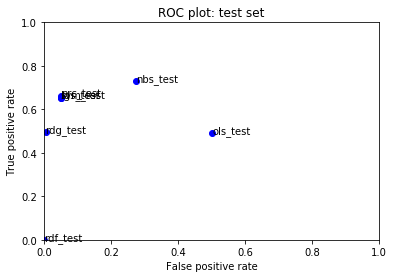

In [46]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

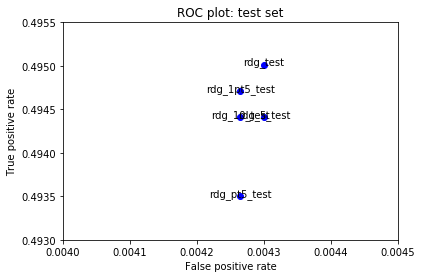

In [89]:
fits = [rdg_performance_test, rdg_pt5_performance_test, rdg_1pt5_performance_test, rdg_5_performance_test, rdg_10_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc, ha = "center")
plt.axis([0.004, .0045, .493, .4955])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/toxiccomments_test.csv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.4837102713431355


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,False
3,00017563c3f7919a,True
4,00017695ad8997eb,True


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation